In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import xgboost as xgb
from xgboost import XGBRegressor

import pickle

In [241]:
data = pd.read_csv('data/concrete_data.csv')
data.head(10)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29


In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [243]:
data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [244]:
data.isna().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

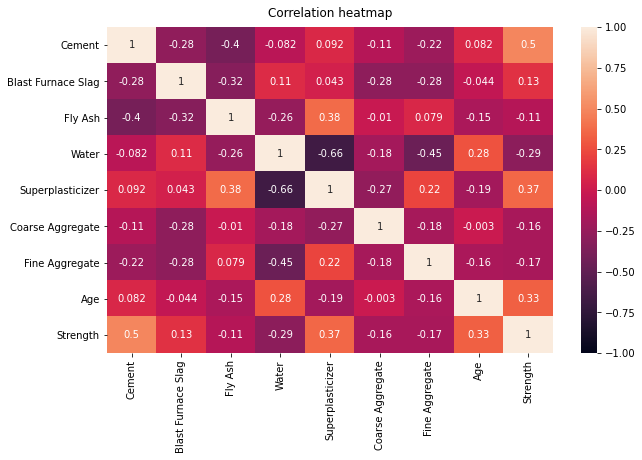

In [245]:
plt.figure(figsize=(10,6))

heatmap = sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1)
heatmap.set_title('Correlation heatmap', pad=10, fontdict={'fontsize':12})

plt.show()


In [246]:
X = data[data.columns[data.columns!='Strength']].values
y = data['Strength']

In [247]:
y.head()

0    79.99
1    61.89
2    40.27
3    41.05
4    44.30
Name: Strength, dtype: float64

In [248]:
X.shape

(1030, 8)

In [249]:
# normalize the dataset

print(f'X mean: {X.mean()}')
print(f'X std: {X.std()}')

X_normalized = (X - X.mean())/X.std()
X_normalized

X mean: 298.6481917475728
X std: 352.3836093554314


array([[ 0.68491213, -0.84750875, -0.84750875, ...,  2.10382035,
         1.07085517, -0.76804989],
       [ 0.68491213, -0.84750875, -0.84750875, ...,  2.1463876 ,
         1.07085517, -0.76804989],
       [ 0.09606522, -0.44311991, -0.84750875, ...,  1.79733617,
         0.83815422, -0.08129831],
       ...,
       [-0.42609301, -0.45191714, -0.53932188, ...,  1.68495864,
         1.36598808, -0.76804989],
       [-0.39601215, -0.31768842, -0.84750875, ...,  1.9607944 ,
         1.39124464, -0.76804989],
       [-0.10712244, -0.5623082 , -0.62530772, ...,  1.60578356,
         1.31348847, -0.76804989]])

In [250]:
## split the dataset

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, 
                                                    test_size = 0.2, 
                                                    shuffle=True, 
                                                    random_state=128)

In [251]:
print(f'Train shape: X = {X_train.shape} ; y={y_train.shape}')
print(f'Test shape: X = {X_test.shape} ; y={y_test.shape}')

Train shape: X = (875, 8) ; y=(875,)
Test shape: X = (155, 8) ; y=(155,)


In [252]:
#Prepare and train the model

model = XGBRegressor(n_jobs=4)

## grid search to find the best model parameter

param_grid = {
        'n_estimators': [50, 100, 500],
        'max_depth': [2, 4, 6, 8, 10],
        'gamma': [0.001, 0.01],
        'learning_rate': [0.01, 0.1, 0.3],
        'booster': ['gbtree']
    }

grid_search_model = GridSearchCV(model, param_grid=param_grid, cv=5, return_train_score=True)

grid_search_model.fit(X_train, y_train)

print(f'Best Score: {grid_search_model.best_score_}')
print(f'Best Param: {grid_search_model.best_params_}')

Best Score: 0.92958820887639
Best Param: {'booster': 'gbtree', 'gamma': 0.001, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500}


In [253]:
## fitting the best model

best_model = grid_search_model.best_estimator_

best_model.fit(X_train, y_train)

print(f'Train Score: {best_model.score(X_train, y_train)}')
print(f'Test Score: {best_model.score(X_test, y_test)}')

Train Score: 0.9802158450442592
Test Score: 0.9453646572493161


In [254]:
prediction = best_model.predict(X_test)

In [259]:
print(f'Mean Absolute Error (MAE): {mae(y_test, prediction)}')
print(f'Mean Squared Error (MSE): {mse(y_test, prediction)}')
print(f'RMSE: {mse(y_test, prediction)**(1/2)}')

Mean Absolute Error (MAE): 2.8762876668130195
Mean Squared Error (MSE): 15.55418372128753
RMSE: 3.943879273163357


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

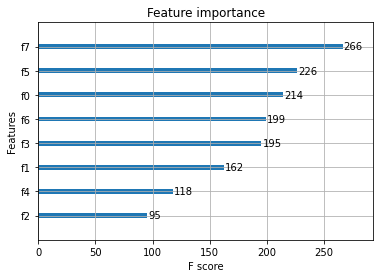

In [256]:
xgb.plot_importance(best_model)

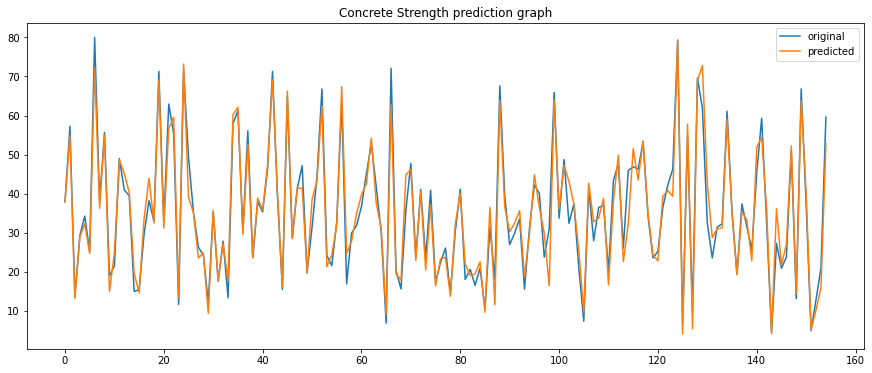

In [257]:
plt.figure(figsize=(15,6))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, prediction, label="predicted")
plt.title("Concrete Strength prediction graph")
plt.legend()
plt.show()

In [263]:
r2_score(y_test, prediction)

0.9453646572493161

In [258]:
# saving the model

pickle.dump(best_model, open('model/concrete-strength-model-20210610.pickle.dat','wb'))
#pickle.dump(best_model, open('model/concrete-strength-model-20210610-wo-normalization.pickle.dat','wb'))